In [1]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=a8c6ca66fbb758d269d49ac452d3475d4627d4185dc484f7561eed98bd879e85
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import numpy as np
import librosa
import pretty_midi
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model


In [4]:
class MusicTranscriber:
    def __init__(self, sr=22050, hop_length=512, n_bins=84, bins_per_octave=12):
        self.sr = sr
        self.hop_length = hop_length
        self.n_bins = n_bins
        self.bins_per_octave = bins_per_octave
        self.fs = sr / hop_length  # Frame rate for piano roll alignmen
        # Calculate sequence_length based on 3 minutes duration
        self.standard_duration = 180
        self.sequence_length = int(np.ceil(self.standard_duration * self.fs))  # Number of frames

    def process_audio(self, audio_path):
        y, _ = librosa.load(audio_path, sr=self.sr, duration=self.standard_duration)
        # Compute CQT
        C = librosa.cqt(
            y,
            sr=self.sr,
            hop_length=self.hop_length,
            n_bins=self.n_bins,
            bins_per_octave=self.bins_per_octave
        )
        # Convert to magnitude and apply log scaling
        C_mag = librosa.amplitude_to_db(np.abs(C), ref=np.max)
        # Pad or truncate to fixed length
        if C_mag.shape[1] < self.sequence_length:
            pad_width = ((0, 0), (0, self.sequence_length - C_mag.shape[1]))
            C_mag = np.pad(C_mag, pad_width, mode='constant')
        else:
            C_mag = C_mag[:, :self.sequence_length]
        return C_mag

    def process_midi(self, midi_path):
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        end_time = self.standard_duration
        # Generate time frames matching the spectrogram
        times = np.linspace(0, end_time, self.sequence_length)
        piano_roll = midi_data.get_piano_roll(fs=self.fs, times=times)
        # Restrict to MIDI note range 21–108 (88 keys)
        piano_roll = piano_roll[21:109, :]
        if piano_roll.shape[1] < self.sequence_length:
            pad_width = ((0, 0), (0, self.sequence_length - piano_roll.shape[1]))
            piano_roll = np.pad(piano_roll, pad_width, mode='constant')
        else:
            piano_roll = piano_roll[:, :self.sequence_length]
        # Normalize to binary values
        piano_roll = (piano_roll > 0).astype(np.float32)
        return piano_roll

    def create_model(self, input_shape, n_pitches):
        # Input layer
        inputs = layers.Input(shape=input_shape)

        # First Convolutional Block
        x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 1))(x)

        # Second Convolutional Block
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        # Reshape for LSTM layer
        x = layers.Permute((2, 1, 3))(x)
        new_height = input_shape[0] // 2

        # Reshape to (batch_size, time_steps, new_height * channels)
        x = layers.Reshape((x.shape[1], new_height * 64))(x)

        # Bidirectional LSTM layers
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

        # Output layer
        outputs = layers.TimeDistributed(layers.Dense(n_pitches, activation='sigmoid'))(x)

        # Create and return the model
        model = Model(inputs=inputs, outputs=outputs)
        return model



    def prepare_dataset(self, audio_files, midi_files):
        spectrograms = []
        piano_rolls = []
        for audio_path, midi_path in zip(audio_files, midi_files):
            try:
                # Process audio
                cqt = self.process_audio(audio_path)
                # Process MIDI
                piano_roll = self.process_midi(midi_path)
                spectrograms.append(cqt)
                piano_rolls.append(piano_roll)
            except Exception as e:
                print(f"Error processing {audio_path}: {str(e)}")
                continue
        # Stack arrays
        X = np.stack(spectrograms)
        y = np.stack(piano_rolls)
        # Add channel dimension for CNN
        X = X[..., np.newaxis]  # Shape: (batch_size, n_bins, time_steps, 1)
        # Transpose y to have shape (batch_size, time_steps, n_pitches)
        y = y.transpose(0, 2, 1)
        return X, y

def segment_data(X, y, segment_length=512, hop_length=256):
    X_segments = []
    y_segments = []
    for i in range(X.shape[0]):  # Iterate over samples
        max_time = X.shape[2]  # Time dimension
        for start in range(0, max_time - segment_length + 1, hop_length):
            end = start + segment_length
            X_segments.append(X[i, :, start:end, :])
            y_segments.append(y[i, start:end, :])
    X_segments = np.array(X_segments)
    y_segments = np.array(y_segments)
    return X_segments, y_segments

In [6]:
transcriber = MusicTranscriber()

audio_files = [f"/content/drive/MyDrive/MT Dataset/maestro/Track00{i}.wav" for i in range(1, 48)]
midi_files = [f"/content/drive/MyDrive/MT Dataset/maestro/Track00{i}.midi" for i in range(1, 48)]

spectrograms, piano_rolls = transcriber.prepare_dataset(audio_files, midi_files)
print(f"Spectrograms shape: {spectrograms.shape}")
print(f"Piano rolls shape: {piano_rolls.shape}")

X_train, X_val, y_train, y_val = train_test_split(spectrograms, piano_rolls, test_size=0.2, random_state=42)


Spectrograms shape: (47, 84, 7752, 1)
Piano rolls shape: (47, 7752, 88)


In [ ]:
    import tensorflow.keras.backend as K

    def focal_loss(alpha=0.35, gamma=3.0):
        def focal_loss_with_logits(y_true, y_pred):
            # Compute cross entropy loss
            bce = K.binary_crossentropy(y_true, y_pred)
            # Compute the modulating factor
            y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
            p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            modulating_factor = K.pow(1.0 - p_t, gamma)
            # Apply alpha weighting
            alpha_weight_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
            # Compute focal loss
            loss = alpha_weight_factor * modulating_factor * bce
            return K.mean(loss)
        return focal_loss_with_logits


    class PianoRollPrecision(tf.keras.metrics.Metric):
        def __init__(self, threshold=0.5, name='piano_roll_precision', **kwargs):
            super().__init__(name=name, **kwargs)
            self.threshold = threshold
            self.true_positives = self.add_weight(name='tp', initializer='zeros')
            self.false_positives = self.add_weight(name='fp', initializer='zeros')

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_true = tf.cast(y_true, tf.float32)

            true_positives = tf.reduce_sum(y_true * y_pred)
            false_positives = tf.reduce_sum((1 - y_true) * y_pred)

            self.true_positives.assign_add(true_positives)
            self.false_positives.assign_add(false_positives)

        def result(self):
            return self.true_positives / (self.true_positives + self.false_positives + K.epsilon())

        def reset_state(self):
            self.true_positives.assign(0.)
            self.false_positives.assign(0.)

    class PianoRollRecall(tf.keras.metrics.Metric):
        def __init__(self,threshold=0.5, name='piano_roll_recall', **kwargs):
            super().__init__(name=name, **kwargs)
            self.threshold = threshold
            self.true_positives = self.add_weight(name='tp', initializer='zeros')
            self.false_negatives = self.add_weight(name='fn', initializer='zeros')

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_pred = tf.cast(y_pred > self.threshold, tf.float32)
            y_true = tf.cast(y_true, tf.float32)

            true_positives = tf.reduce_sum(y_true * y_pred)
            false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

            self.true_positives.assign_add(true_positives)
            self.false_negatives.assign_add(false_negatives)

        def result(self):
            return self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())

        def reset_state(self):
            self.true_positives.assign(0.)
            self.false_negatives.assign(0.)

    class PianoRollF1Score(tf.keras.metrics.Metric):
        def __init__(self, name='piano_roll_f1', **kwargs):
            super().__init__(name=name, **kwargs)
            self.precision = PianoRollPrecision()
            self.recall = PianoRollRecall()

        def update_state(self, y_true, y_pred, sample_weight=None):
            self.precision.update_state(y_true, y_pred, sample_weight)
            self.recall.update_state(y_true, y_pred, sample_weight)

        def result(self):
            p = self.precision.result()
            r = self.recall.result()
            return 2 * ((p * r) / (p + r + K.epsilon()))

        def reset_state(self):
            self.precision.reset_state()
            self.recall.reset_state()


    # Segment the data
    segment_length = 512
    hop_length = 256
    X_train_seg, y_train_seg = segment_data(X_train, y_train, segment_length, hop_length)
    X_val_seg, y_val_seg = segment_data(X_val, y_val, segment_length, hop_length)

    print(f"Segmented X_train shape: {X_train_seg.shape}")
    print(f"Segmented y_train shape: {y_train_seg.shape}")

    # Create the model
    input_shape = X_train_seg.shape[1:]  # (n_bins, segment_length, 1)
    n_pitches = y_train_seg.shape[2]     # Should be 88 (number of pitches)

    model = transcriber.create_model(input_shape, n_pitches)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.35, gamma=4.0), metrics=[PianoRollPrecision(0.4), PianoRollRecall(0.4), PianoRollF1Score()])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]

    history = model.fit(
        X_train_seg, y_train_seg,
        validation_data=(X_val_seg, y_val_seg),
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=callbacks
    )




Segmented X_train shape: (1073, 84, 512, 1)
Segmented y_train shape: (1073, 512, 88)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 53s 630ms/step - loss: 0.0114 - piano_roll_f1: 0.0529 - piano_roll_precision: 0.0716 - piano_roll_recall: 0.2775 - val_loss: 0.0060 - val_piano_roll_f1: 0.0000e+00 - val_piano_roll_precision: 0.1185 - val_piano_roll_recall: 0.0019
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - loss: 0.0064 - piano_roll_f1: 0.0000e+00 - piano_roll_precision: 0.2082 - piano_roll_recall: 0.0228 - val_loss: 0.0058 - val_piano_roll_f1: 0.0000e+00 - val_piano_roll_precision: 0.2144 - val_piano_roll_recall: 0.0364
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 430ms/step - loss: 0.0060 - piano_roll_f1: 0.0022 - piano_roll_precision: 0.3175 - piano_roll_recall: 0.1859 - val_loss: 0.0055 - val_piano_roll_f1: 0.0080 - val_piano_roll_precision: 0.2628 - val_piano_roll_recall: 0.3878
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - loss: 0.0054 - piano_roll_f1: 0.0605 - piano_roll_pre

In [ ]:
model.save('piano_transcriberF1.h5')
model.save('piano_transcriberF1.keras')

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_sparse_piano_roll(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred to 1D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Identify active regions (where either y_true or y_pred is positive)
    active_regions = (y_true_flat > 0) | (y_pred_flat > 0)

    # Calculate standard metrics on active regions
    precision = precision_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)
    recall = recall_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)
    f1 = f1_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)

    # Note-wise accuracy (focusing on active notes)
    true_positives = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    false_positives = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    false_negatives = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    note_precision = true_positives / (true_positives + false_positives + epsilon)
    note_recall = true_positives / (true_positives + false_negatives + epsilon)
    note_f1 = 2 * (note_precision * note_recall) / (note_precision + note_recall + epsilon)

    return {
        'active_precision': precision,
        'active_recall': recall,
        'active_f1': f1,
        'note_precision': note_precision,
        'note_recall': note_recall,
        'note_f1': note_f1
    }


In [9]:
def evaluate_framewise_piano_roll(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred to 1D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate standard metrics for the entire dataset and not just active regions
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

    return {
        'frame_precision': precision,
        'frame_recall': recall,
        'frame_f1': f1
    }


In [10]:
predictions = model.predict(X_val_seg)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.float32)

def evaluate_all_metrics(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Framewise metrics
    frame_metrics = evaluate_framewise_piano_roll(y_true, y_pred)

    # Note-wise metrics
    note_metrics = evaluate_sparse_piano_roll(y_true, y_pred, epsilon)

    return {**frame_metrics, **note_metrics}


metrics = evaluate_all_metrics(y_val_seg, binary_predictions)

print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 563ms/step
Evaluation Metrics:
frame_precision: 0.7817
frame_recall: 0.4915
frame_f1: 0.6035
active_precision: 0.7817
active_recall: 0.4915
active_f1: 0.6035
note_precision: 0.7817
note_recall: 0.4915
note_f1: 0.6035


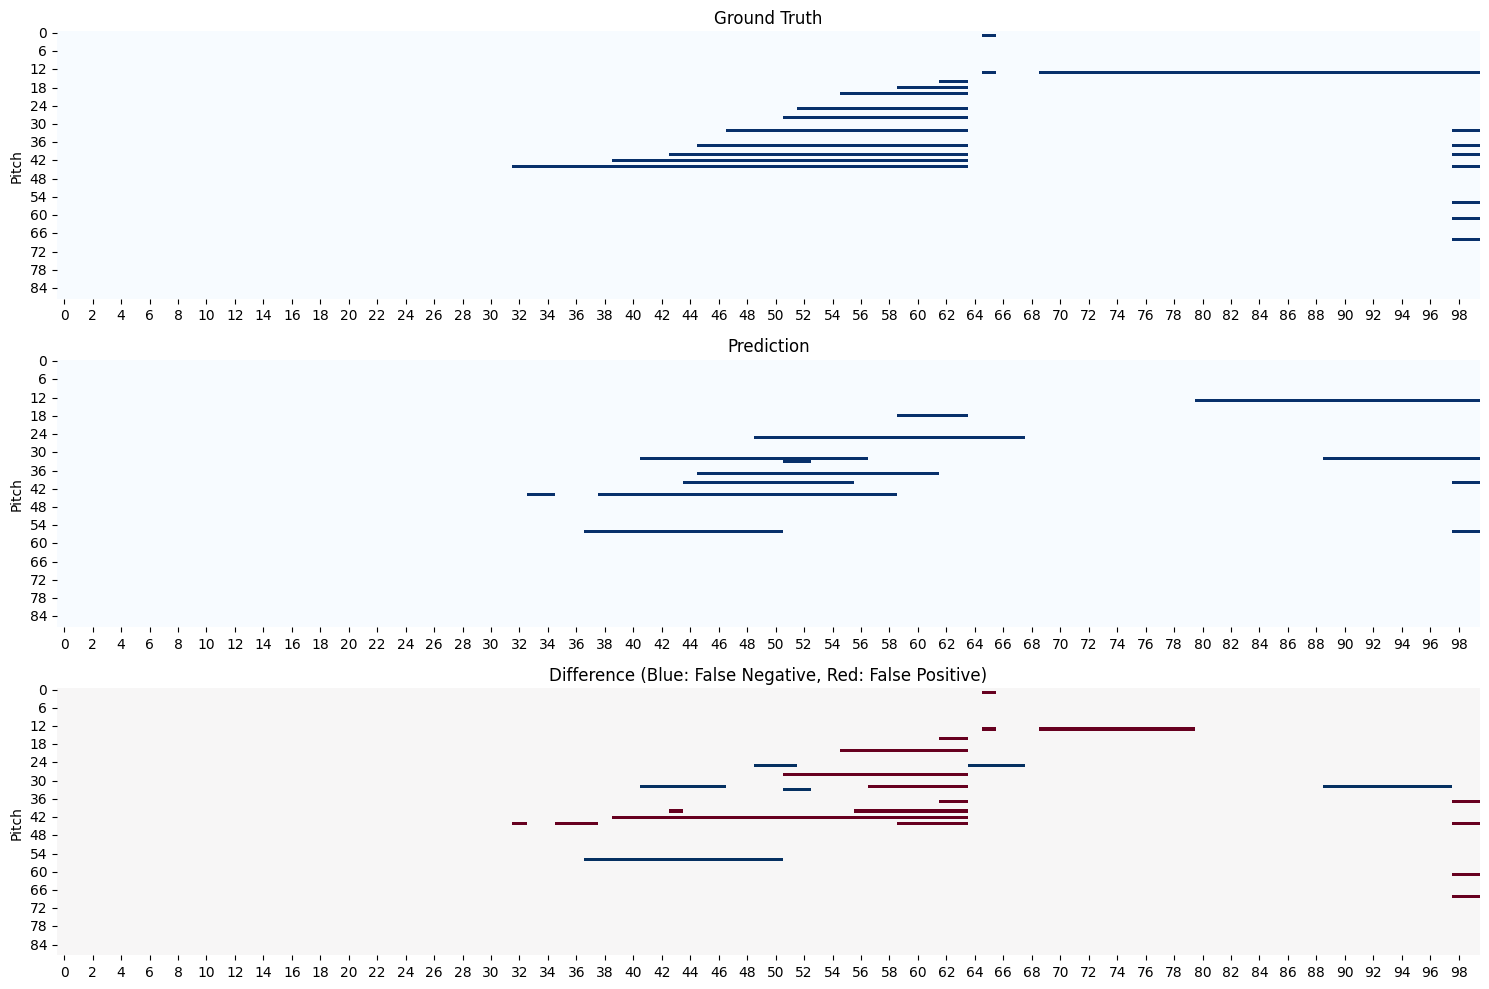

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_comparison(y_true, y_pred, sample_idx=0, start_idx=0, length=100):
    y_true_sample = y_true[sample_idx]
    y_pred_sample = y_pred[sample_idx]

    # Select the segment
    y_true_segment = y_true_sample[start_idx:start_idx+length]
    y_pred_segment = y_pred_sample[start_idx:start_idx+length]

    # Compute the difference
    difference = y_true_segment - y_pred_segment

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    sns.heatmap(y_true_segment.T, ax=axes[0], cmap='Blues', cbar=False)
    axes[0].set_title('Ground Truth')
    axes[0].set_ylabel('Pitch')

    sns.heatmap(y_pred_segment.T, ax=axes[1], cmap='Blues', cbar=False)
    axes[1].set_title('Prediction')
    axes[1].set_ylabel('Pitch')

    sns.heatmap(difference.T, ax=axes[2], cmap='RdBu_r', center=0, cbar=False)
    axes[2].set_title('Difference (Blue: False Negative, Red: False Positive)')
    axes[2].set_ylabel('Pitch')

    plt.tight_layout()
    plt.show()


visualize_comparison(y_val_seg, binary_predictions, sample_idx=0, start_idx=0, length=100)


In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def frame_level_metrics(y_true, y_pred, threshold=0.5):

    y_pred_bin = (y_pred > threshold).astype(np.int32)

    precision = precision_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    recall = recall_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    f1 = f1_score(y_true.flatten(), y_pred_bin.flatten(), zero_division=0)
    accuracy = accuracy_score(y_true.flatten(), y_pred_bin.flatten())

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}


In [14]:
def note_level_metrics(y_true, y_pred, threshold=0.5):

    y_pred_bin = (y_pred > threshold).astype(np.int32)

    # Onsets are where the note transitions from 0 to 1
    onsets_true = np.diff(y_true, axis=0, prepend=0).clip(0, 1)
    onsets_pred = np.diff(y_pred_bin, axis=0, prepend=0).clip(0, 1)

    precision = precision_score(onsets_true.flatten(), onsets_pred.flatten(), zero_division=0)
    recall = recall_score(onsets_true.flatten(), onsets_pred.flatten(), zero_division=0)
    f1 = f1_score(onsets_true.flatten(), onsets_pred.flatten(), zero_division=0)

    return {"onset_precision": precision, "onset_recall": recall, "onset_f1": f1}


In [15]:
def pitch_level_metrics(y_true, y_pred, threshold=0.5):

    y_pred_bin = (y_pred > threshold).astype(np.int32)

    precision = precision_score(y_true.T.flatten(), y_pred_bin.T.flatten(), zero_division=0)
    recall = recall_score(y_true.T.flatten(), y_pred_bin.T.flatten(), zero_division=0)
    f1 = f1_score(y_true.T.flatten(), y_pred_bin.T.flatten(), zero_division=0)

    return {"pitch_precision": precision, "pitch_recall": recall, "pitch_f1": f1}


In [16]:
def time_based_metrics(onsets_true, onsets_pred, sr, hop_length):
    from scipy.spatial.distance import cdist

    # Convert onsets to time (in seconds)
    times_true = np.where(onsets_true == 1)[0] * (hop_length / sr)
    times_pred = np.where(onsets_pred == 1)[0] * (hop_length / sr)

    # Compute temporal deviation
    if len(times_true) > 0 and len(times_pred) > 0:
        distances = cdist(times_true[:, None], times_pred[:, None], metric="euclidean")
        temporal_deviation = distances.min(axis=1).mean()
    else:
        temporal_deviation = None

    missed_onsets = len(times_true) - len(times_pred)
    return {"temporal_deviation": temporal_deviation, "missed_onsets": missed_onsets}


In [33]:
def polyphonic_metrics(y_true, y_pred, threshold=0.5):

    y_pred_bin = (y_pred > threshold).astype(np.int32)

    # Compute per-frame metrics
    frame_precision = np.sum((y_pred_bin & y_true), axis=1) / np.maximum(np.sum(y_pred_bin, axis=1), 1)
    frame_recall = np.sum((y_pred_bin & y_true), axis=1) / np.maximum(np.sum(y_true, axis=1), 1)

    return {
        "polyphonic_precision": np.mean(frame_precision),
        "polyphonic_recall": np.mean(frame_recall),
    }


In [19]:
# Call each metric function and collect results
def evaluate_all_metrics(y_true, y_pred, sr=22050, hop_length=512, threshold=0.5):

    metrics = {}

    # Frame-Level Metrics
    metrics.update(frame_level_metrics(y_true, y_pred, threshold))

    # Note-Level Metrics
    metrics.update(note_level_metrics(y_true, y_pred, threshold))

    # Pitch-Level Metrics
    metrics.update(pitch_level_metrics(y_true, y_pred, threshold))

    # Time-Based Metrics (using only onsets from the first sample)
    onsets_true = np.diff(y_true[0], axis=0, prepend=0).clip(0, 1)
    onsets_pred = np.diff((y_pred[0] > threshold).astype(np.int32), axis=0, prepend=0).clip(0, 1)
    metrics.update(time_based_metrics(onsets_true, onsets_pred, sr, hop_length))

    return metrics


y_pred = model.predict(X_val_seg)
all_metrics = evaluate_all_metrics(y_val_seg, y_pred)

# Print metrics
for metric, value in all_metrics.items():
    print(f"{metric}: {value:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
precision: 0.7817
recall: 0.4915
f1: 0.6035
accuracy: 0.9653
onset_precision: 0.6824
onset_recall: 0.4583
onset_f1: 0.5484
pitch_precision: 0.7817
pitch_recall: 0.4915
pitch_f1: 0.6035
temporal_deviation: 0.0530
missed_onsets: 8.0000


In [ ]:
def polyphonic_metrics(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred > threshold).astype(int)

    # Reshape y_true and y_pred_binary to 2D (flatten time and pitch dimensions)
    y_true_flat = y_true.reshape(-1, y_true.shape[-1])  # (num_samples * time_steps, num_pitches)
    y_pred_flat = y_pred_binary.reshape(-1, y_pred.shape[-1])  # Same shape as y_true_flat

    # Compute precision, recall, and F1-score using 'micro' averaging
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0, average='micro')

    # Missed onsets: Count false negatives (ground truth is 1, prediction is 0)
    missed_onsets = np.sum(np.logical_and(y_true_flat == 1, y_pred_flat == 0))

    return {
        "poly_precision": precision,
        "poly_recall": recall,
        "poly_f1": f1,
        "missed_onsets": missed_onsets
    }

print(polyphonic_metrics(y_val_seg, y_pred))


{'poly_precision': 0.7816904435971989, 'poly_recall': 0.4915085199343843, 'poly_f1': 0.603530986097572, 'missed_onsets': 357409}


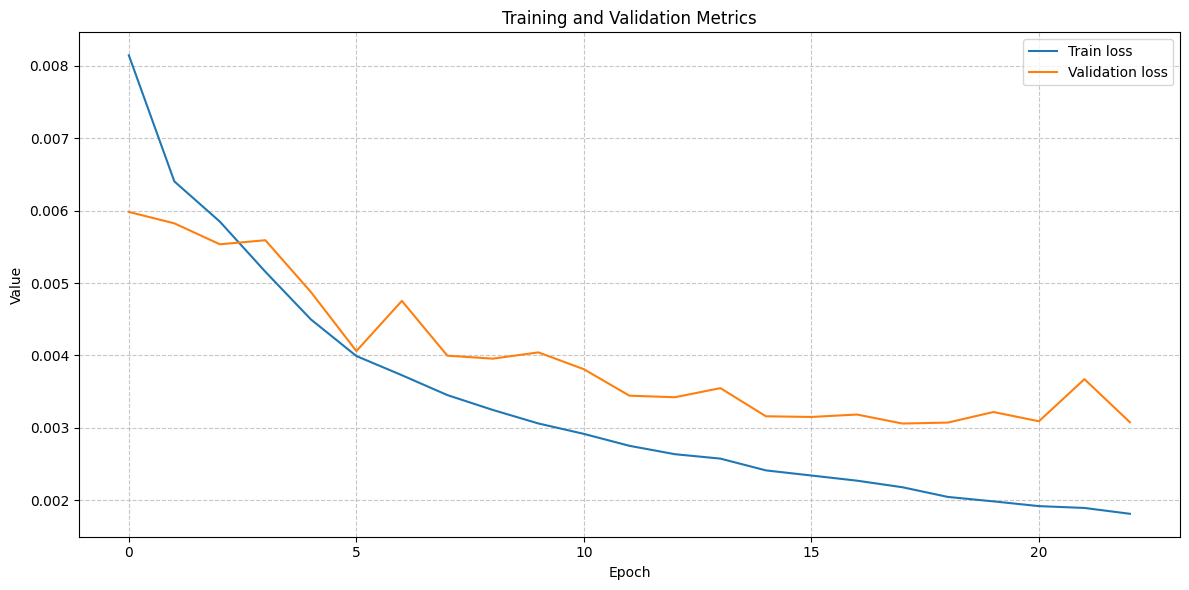

In [ ]:
def plot_training_history(history, metrics=["accuracy", "loss"], title="Training History"):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], label=f"Train {metric}")
            plt.plot(history.history[f"val_{metric}"], label=f"Validation {metric}")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_training_history(history, metrics=["accuracy", "loss", "precision", "recall"], title="Training and Validation Metrics")


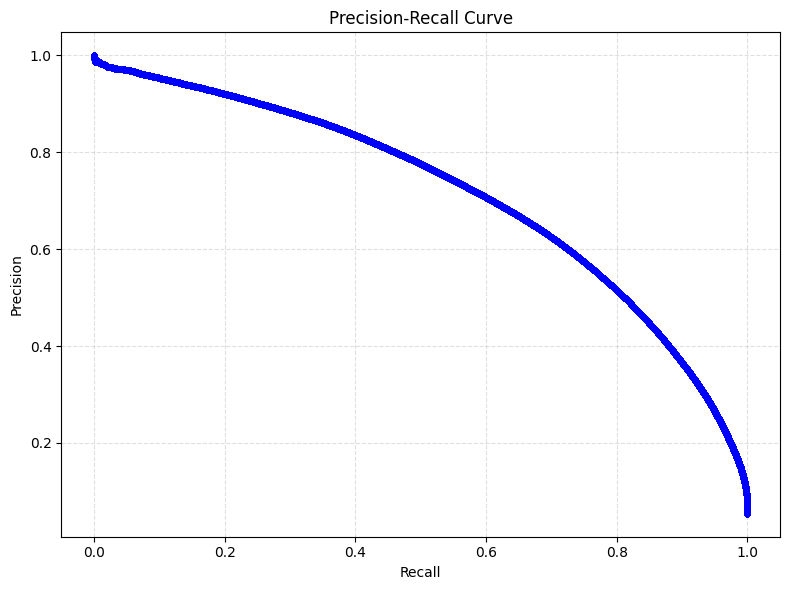

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_pred, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color='b')
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_precision_recall(y_val_seg, y_pred)


## WRITE MIDI


In [ ]:

# def segment_features(features, segment_length=512, hop_length=256):
#     segments = []
#     max_time = features.shape[1]
#     for start in range(0, max_time - segment_length + 1, hop_length):
#         end = start + segment_length
#         segments.append(features[:, start:end, :])
#     return np.array(segments)



In [ ]:

# def piano_roll_to_midi(piano_roll, fs=43.06, program=0, velocity=100):
#     midi = pretty_midi.PrettyMIDI()
#     instrument = pretty_midi.Instrument(program=program)

#     time_per_frame = 1.0 / fs

#     for pitch in range(piano_roll.shape[1]):
#         # Find all contiguous segments of 'on' notes
#         active_times = np.where(piano_roll[:, pitch] > 0.5)[0]
#         if len(active_times) == 0:
#             continue

#         # Group contiguous times
#         note_start = active_times[0]
#         for i in range(1, len(active_times)):
#             if active_times[i] != active_times[i - 1] + 1:
#                 # Note off
#                 note_end = active_times[i - 1]
#                 start_time = note_start * time_per_frame
#                 end_time = (note_end + 1) * time_per_frame
#                 note = pretty_midi.Note(velocity=velocity, pitch=pitch + 21, start=start_time, end=end_time)
#                 instrument.notes.append(note)
#                 # Update note start
#                 note_start = active_times[i]

#         # Add the final note
#         note_end = active_times[-1]
#         start_time = note_start * time_per_frame
#         end_time = (note_end + 1) * time_per_frame
#         note = pretty_midi.Note(velocity=velocity, pitch=pitch + 21, start=start_time, end=end_time)
#         instrument.notes.append(note)

#     midi.instruments.append(instrument)

#     return midi

In [ ]:

# import os
# import IPython.display as ipd
# import numpy as np
# import librosa
# import tensorflow as tf
# import pretty_midi

# audio_file = "Track002.wav"
# ipd.display(ipd.Audio(filename=audio_file))

In [ ]:

# transcriber = MusicTranscriber()
# cqt = transcriber.process_audio(audio_file)
# cqt = np.expand_dims(cqt, axis=-1)

# # Segment the input into slices of length 512
# segments = segment_features(cqt, segment_length=512, hop_length=256)

# model_path = 'piano_transcriberF1.keras'
# model = tf.keras.models.load_model(model_path, compile=False)


# predictions = model.predict(segments)

# piano_roll = np.concatenate(predictions, axis=0)

# midi = piano_roll_to_midi(piano_roll, fs=43.06)
# midi.write('output.midi')


In [ ]:
# import pretty_midi
# import numpy as np
# import matplotlib.pyplot as plt

# def display_piano_roll(midi_file, fs=100):

#     midi_data = pretty_midi.PrettyMIDI(midi_file)

#     piano_roll = midi_data.get_piano_roll(fs=fs)

#     plt.figure(figsize=(15, 6))
#     plt.imshow(
#         piano_roll[21:109],
#         aspect='auto',
#         origin='lower',
#         cmap='gray_r',
#         interpolation='nearest',
#     )
#     plt.title('Piano Roll')
#     plt.xlabel('Time (frames)')
#     plt.ylabel('Pitch (MIDI Notes)')
#     plt.colorbar(label='Velocity')
#     plt.show()

# midi_file = 'output.midi'
# display_piano_roll(midi_file)
